 <h1> Final Exam: Model Deployment in the Cloud </h1>
Name: Valencia, Aaron Jonathan G. <br>
Course and Section: CPE 019 - CPE32S1 <br>
Instructor: Engr. Robin Valenzuela<br>
Date Performed: July 8, 2025<br>
Date Submitted: July 11, 2025</b>


**DATASET**
https://www.kaggle.com/datasets/shawngano/gano-cat-breed-image-collection/data

### Import libraries and dataset



---



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from keras.utils import get_custom_objects

In [4]:
mixed_precision.set_global_policy('mixed_float16')

In [21]:
!cp -r "/content/drive/MyDrive/dataset/Gano-Cat-Breeds" /content/
PATH = "/content/Gano-Cat-Breeds"
img_height, img_width = 128, 128
batch_size = 32

In [6]:
import shutil
import os

# Recursively remove all `.ipynb_checkpoints` folders
def remove_checkpoints(path):
    for root, dirs, files in os.walk(path):
        for d in dirs:
            if d == ".ipynb_checkpoints":
                shutil.rmtree(os.path.join(root, d))
                print(f"Removed: {os.path.join(root, d)}")

remove_checkpoints("/content/drive/MyDrive/dataset")


Removed: /content/drive/MyDrive/dataset/.ipynb_checkpoints




---




### Showing dataset samples



---



In [51]:
def make_dataFrame(data):
    path=pathlib.Path(data)
    filepaths=list(path.glob(r"*/*.jpg"))
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
    d1=pd.Series(filepaths,name='filepaths').astype(str)
    d2=pd.Series(labels,name='labels')
    df=pd.concat([d1,d2],axis=1)
    return df

In [52]:
dataset = make_dataFrame(PATH)
dataset

,filepaths,labels
0,/content/Gano-Cat-Breeds/Sphynx/Sphynx_124.jpg,Sphynx
1,/content/Gano-Cat-Breeds/Sphynx/Sphynx_24.jpg,Sphynx
2,/content/Gano-Cat-Breeds/Sphynx/Sphynx_56.jpg,Sphynx
3,/content/Gano-Cat-Breeds/Sphynx/Sphynx_105.jpg,Sphynx
4,/content/Gano-Cat-Breeds/Sphynx/Sphynx_90.jpg,Sphynx
...,...,...
1491,/content/Gano-Cat-Breeds/Egyptian Mau/Egyptian...,Egyptian Mau
1492,/content/Gano-Cat-Breeds/Egyptian Mau/Egyptian...,Egyptian Mau
1493,/content/Gano-Cat-Breeds/Egyptian Mau/Egyptian...,Egyptian Mau
1494,/content/Gano-Cat-Breeds/Egyptian Mau/Egyptian...,Egyptian Mau


In [53]:
class_names = dataset['labels'].unique()
class_names

array(['Sphynx', 'Ragdoll', 'Maine Coon', 'Persian', 'Tuxedo', 'Siamese',
       'Bengal', 'Egyptian Mau'], dtype=object)

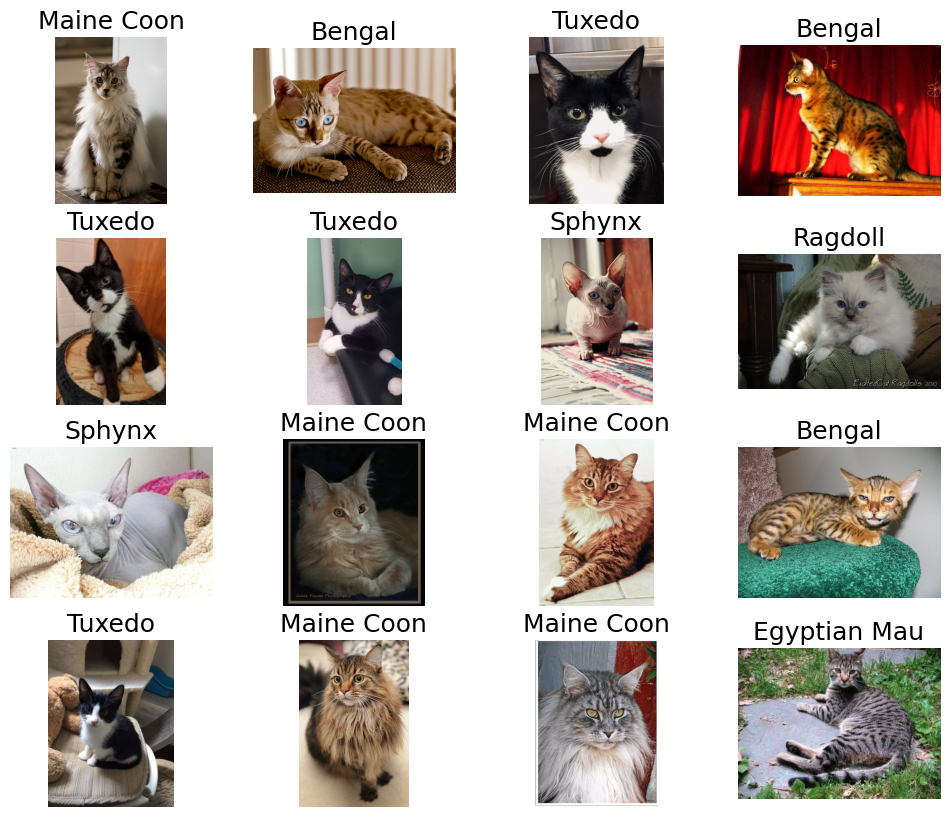

In [54]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,10))
for i,ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(dataset))
    x = plt.imread(dataset.iloc[idx]['filepaths'])
    ax.imshow(x)
    ax.set_title(dataset['labels'][idx], fontsize=18)
    ax.set_axis_off()
plt.show()

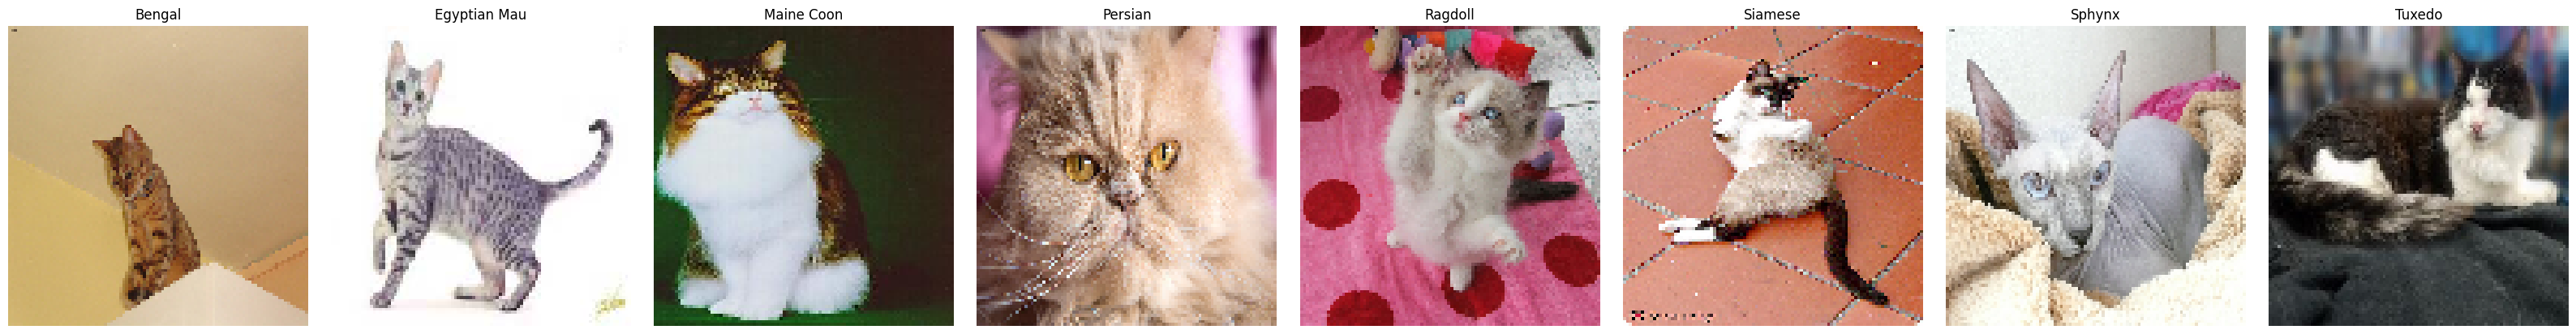

In [55]:

class_names = sorted(os.listdir(PATH))
fig, axes = plt.subplots(1, len(class_names), figsize=(4 * len(class_names), 4))

for i, cls in enumerate(class_names):
    class_path = os.path.join(PATH, cls)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        axes[i].axis('off')
        axes[i].set_title(f"{cls}\n(no images)", fontsize=10)
        continue


    img_path = os.path.join(class_path, image_files[0])
    img = load_img(img_path, target_size=(100, 100))
    axes[i].imshow(img)
    axes[i].set_title(cls, fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.show()




---



### Data augmentation



---



In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 1200 images belonging to 8 classes.
Found 296 images belonging to 8 classes.




---



### Creating base model



---



In [8]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2,2),

    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),  # Less aggressive dropout for faster convergence
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,080 (1.55 MB)

 Trainable params: 407,080 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

**Model Training and saving**

In [10]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.1514 - loss: 2.1059 - val_accuracy: 0.2162 - val_loss: 2.0145
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.2129 - loss: 1.9999 - val_accuracy: 0.2669 - val_loss: 1.9055
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.2834 - loss: 1.8987 - val_accuracy: 0.3615 - val_loss: 1.7393
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.3188 - loss: 1.7816 - val_accuracy: 0.3446 - val_loss: 1.7241
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.3273 - loss: 1.7339 - val_accuracy: 0.3682 - val_loss: 1.6368
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.3691 - loss: 1.6367 - val_accuracy: 0.4291 - val_loss: 1.5601
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/step - accuracy: 0.4000 - loss: 1.5960 - val_accuracy: 0.4257 - val_loss: 1.5065
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.4291 - loss: 1.4991 - val_accuracy:

In [12]:
loss, acc = model.evaluate(validation_generator)
print(f"Final validation accuracy: {acc:.2f}")

results = model.evaluate(validation_generator)
print(f"Test loss: {results[0]:.2f}, Test accuracy: {results[1]:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.5234 - loss: 1.3440
Final validation accuracy: 0.52
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.4893 - loss: 1.3515
Test loss: 1.35, Test accuracy: 0.49


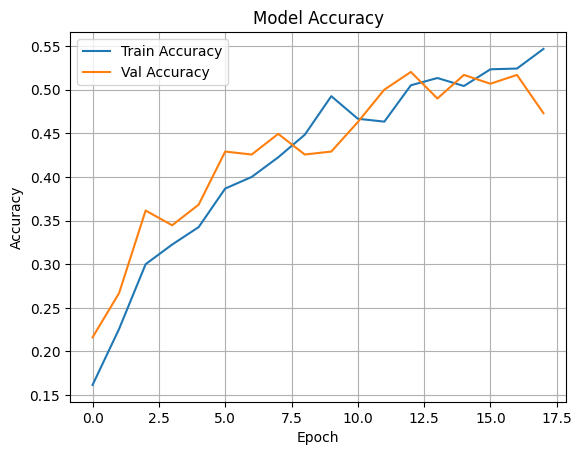

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
model.save("/content/drive/MyDrive/dataset/finals-model/model.h5")

**USING MobileNetV2**

In [62]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)



Found 1200 images belonging to 8 classes.
Found 296 images belonging to 8 classes.


In [34]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

#

In [35]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 470ms/step - accuracy: 0.2997 - loss: 2.1034 - val_accuracy: 0.7905 - val_loss: 0.6407 - learning_rate: 5.0000e-04
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - accuracy: 0.7376 - loss: 0.7386 - val_accuracy: 0.8480 - val_loss: 0.4319 - learning_rate: 5.0000e-04
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.8021 - loss: 0.5156 - val_accuracy: 0.8986 - val_loss: 0.3762 - learning_rate: 5.0000e-04
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.8210 - loss: 0.4999 - val_accuracy: 0.8649 - val_loss: 0.3668 - learning_rate: 5.0000e-04
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 266ms/step - accuracy: 0.8540 - loss: 0.4000 - val_accuracy: 0.8818 - val_loss: 0.3680 - learning_rate: 5.0000e-04
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.8791 - loss: 0.3411 - val_accuracy: 0.8716 - val_loss: 0.3596 - learning_rate: 5.0000e-04
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accu

In [36]:
loss, acc = model.evaluate(validation_generator)
print(f"Final validation accuracy: {acc:.2f}")

results = model.evaluate(validation_generator)
print(f"Test loss: {results[0]:.2f}, Test accuracy: {results[1]:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.8557 - loss: 0.4097
Final validation accuracy: 0.88
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.8752 - loss: 0.3332
Test loss: 0.30, Test accuracy: 0.88


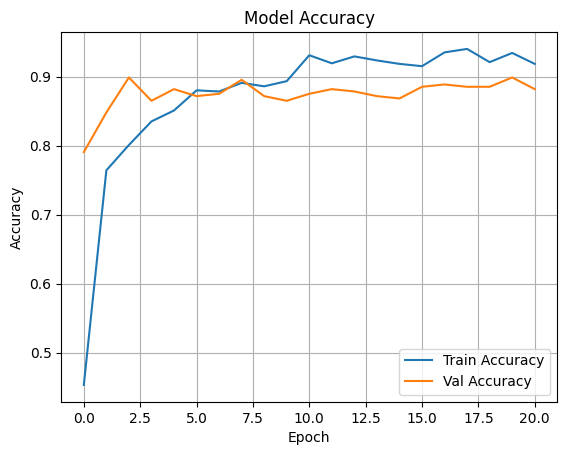

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [63]:
model.save("/content/drive/MyDrive/dataset/finals-model/v2_model.keras")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


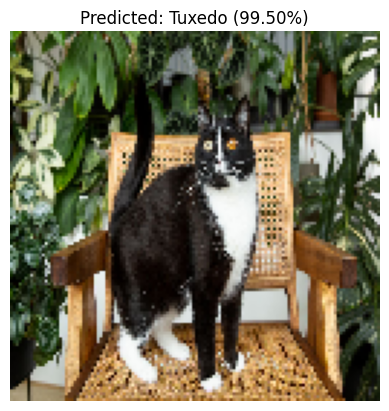

In [61]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np

img_path = '/content/image_2025-07-11_174302508.png'
image_size = (128, 128)

img = load_img(img_path, target_size=image_size)
img_array = img_to_array(img) / 255.0
img_array_expanded = np.expand_dims(img_array, axis=0)

custom_objects = {
    "Cast": tf.keras.layers.Layer  # placeholder for compatibility
}

sample_model = load_model("v2_model.keras")

prediction = sample_model.predict(img_array_expanded)
predicted_index = np.argmax(prediction)
predicted_class = class_names[predicted_index]
confidence = prediction[0][predicted_index] * 100

plt.imshow(img_array)
plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
plt.axis('off')
plt.show()
